In [1]:
import pandas as pd
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import langid
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2640-\u2642"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [3]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text)  # Removing @mentions
    text = re.sub('#', '', text)  # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text)  # Removing RT
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub("\n", "", text)  # Removing hyperlink
    text = re.sub(":", "", text)  # Removing hyperlink
    text = re.sub("_", "", text)  # Removing hyperlink
    text = re.sub(r"[^\w\s]", '', text)  # Removing Puncuation
    text = emoji_pattern.sub(r'', text)  # Removing Number in token
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.lower()
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub(r"\b[a-zA-z]\b", '', text)  # Removing single char
    return text


def tokenizing(text):
    return word_tokenize(text)


def removeStopwords(tokens):
    eng_stopwords = stopwords.words('english')
    return [i for i in tokens if i not in eng_stopwords]


def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(term) for term in tokens]


def joinText(tokens):
    text = " ".join(tokens)
    return text

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getTextblobLabel(x):
    if( x < 0):
        return "Negative"
    if(x == 0):
        return "Netral"
    if(x > 0):
        return "Positive"

def getRatingLabel(rating):
    if rating == 1 or rating ==2:
        return "Negative"
    if rating == 3:
        return "Netral"
    if rating == 4 or rating == 5 :
        return "Positive"    


In [4]:
df = pd.read_csv("GH_Bali_Review.csv")
df = df.drop_duplicates()

In [5]:
len(df)

3790

In [6]:
df['language'] = df['Review'].apply(lambda x: langid.classify(x)[0])
df = df[df['language'] == 'en']
df = df.drop('language', axis=1)

In [7]:
df.head(10)

,Rating,Review
0,5,Room was clean and neat. Food was good and atm...
1,4,A fantastic resort in a great location. Beauti...
2,5,We really enjoyed our stay. The staff were ver...
3,5,"Excellent , Start to finish this property took..."
4,5,This hotel is really amazing. We had a wonderf...
5,5,"Could not fault our stay, the facilities are e..."
6,5,It was a great experience and services and all...
7,5,GH is a true 5 star hotel. All staff from gard...
8,1,If you don’t like BUGS in your Bed do not come...
9,4,Grand Hyatt Bali is a hotel next to the beach....


In [8]:
df.isnull().sum()

Rating    0
Review    0
dtype: int64

## Preprocessing

In [9]:
def preprocessing(dtf):
    dtf['Review'] = dtf['Review'].apply(cleanTxt)
    dtf['Review'] = dtf['Review'].apply(tokenizing)
    dtf['Review'] = dtf['Review'].apply(removeStopwords)
    dtf['Review'] = dtf['Review'].apply(stemming)
    dtf['Review'] = dtf['Review'].apply(joinText)
    return dtf

In [10]:
df['Review'] = df['Review'].apply(cleanTxt)
df.head(8)

,Rating,Review
0,5,room was clean and neat food was good and atmo...
1,4,fantastic resort in great location beautiful...
2,5,we really enjoyed our stay the staff were very...
3,5,excellent start to finish this property took ...
4,5,this hotel is really amazing we had wonderful...
5,5,could not fault our stay the facilities are ex...
6,5,it was great experience and services and all ...
7,5,gh is true star hotel all staff from gardene...


In [11]:
df['Review'] = df['Review'].apply(tokenizing)
df.head(8)

,Rating,Review
0,5,"[room, was, clean, and, neat, food, was, good,..."
1,4,"[fantastic, resort, in, great, location, beaut..."
2,5,"[we, really, enjoyed, our, stay, the, staff, w..."
3,5,"[excellent, start, to, finish, this, property,..."
4,5,"[this, hotel, is, really, amazing, we, had, wo..."
5,5,"[could, not, fault, our, stay, the, facilities..."
6,5,"[it, was, great, experience, and, services, an..."
7,5,"[gh, is, true, star, hotel, all, staff, from, ..."


In [12]:
df['Review'] = df['Review'].apply(removeStopwords)
df.head(8)

,Rating,Review
0,5,"[room, clean, neat, food, good, atmosphere, br..."
1,4,"[fantastic, resort, great, location, beautiful..."
2,5,"[really, enjoyed, stay, staff, accommodating, ..."
3,5,"[excellent, start, finish, property, took, car..."
4,5,"[hotel, really, amazing, wonderful, time, kids..."
5,5,"[could, fault, stay, facilities, excellent, se..."
6,5,"[great, experience, services, kind, facilities..."
7,5,"[gh, true, star, hotel, staff, gardeners, mana..."


In [13]:
df['Review'] = df['Review'].apply(stemming)
df.head(8)

,Rating,Review
0,5,"[room, clean, neat, food, good, atmospher, bri..."
1,4,"[fantast, resort, great, locat, beauti, ocean,..."
2,5,"[realli, enjoy, stay, staff, accommod, ate, se..."
3,5,"[excel, start, finish, properti, took, care, u..."
4,5,"[hotel, realli, amaz, wonder, time, kid, staff..."
5,5,"[could, fault, stay, facil, excel, servic, per..."
6,5,"[great, experi, servic, kind, facil, stateofth..."
7,5,"[gh, true, star, hotel, staff, garden, manag, ..."


In [14]:
df['Review'] = df['Review'].apply(joinText)
df.head()

,Rating,Review
0,5,room clean neat food good atmospher brilliant ...
1,4,fantast resort great locat beauti ocean view r...
2,5,realli enjoy stay staff accommod ate sever res...
3,5,excel start finish properti took care us staff...
4,5,hotel realli amaz wonder time kid staff help c...


## Analisis Sentimen berdasarkan Labelling menggunakan TextBlob

In [15]:
df['Polarity'] = df['Review'].apply(getPolarity)
df['Textblob_Label'] = df['Polarity'].apply(getTextblobLabel)

In [16]:
df.head()

,Rating,Review,Polarity,Textblob_Label
0,5,room clean neat food good atmospher brilliant ...,0.553333,Positive
1,4,fantast resort great locat beauti ocean view r...,0.337500,Positive
2,5,realli enjoy stay staff accommod ate sever res...,0.607143,Positive
3,5,excel start finish properti took care us staff...,0.306250,Positive
4,5,hotel realli amaz wonder time kid staff help c...,0.400000,Positive


In [17]:
df['Textblob_Label'].value_counts()

Positive    3560
Negative     174
Netral        54
Name: Textblob_Label, dtype: int64

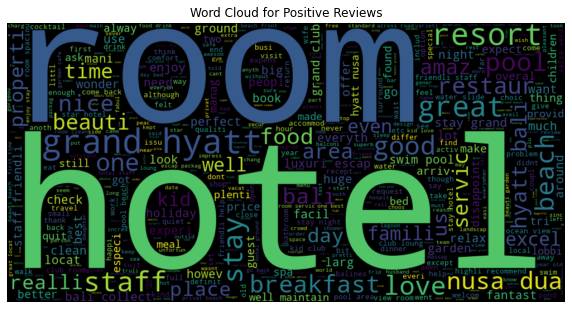

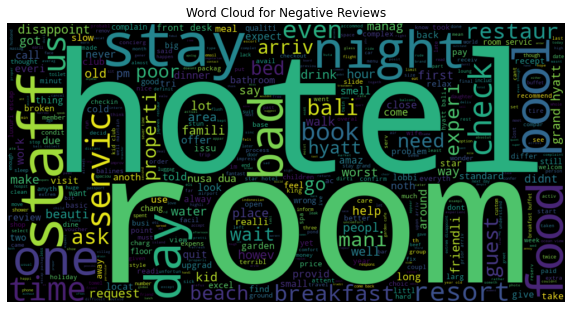

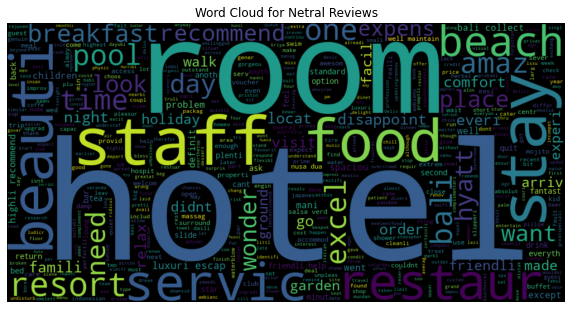

In [18]:
def generate_wordcloud_tb(df, sentiment_label):
    plt.figure(figsize=(10, 10))

    sentiment_text = df.loc[df['Textblob_Label'] == sentiment_label, 'Review']
    sentiment_text = sentiment_text.str.cat(sep=' ')

    wc = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    wordcloud = wc.generate(sentiment_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Reviews')
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and 'Textblob_Label' contains sentiment labels
generate_wordcloud_tb(df, 'Positive')
generate_wordcloud_tb(df, 'Negative')
generate_wordcloud_tb(df, 'Netral')

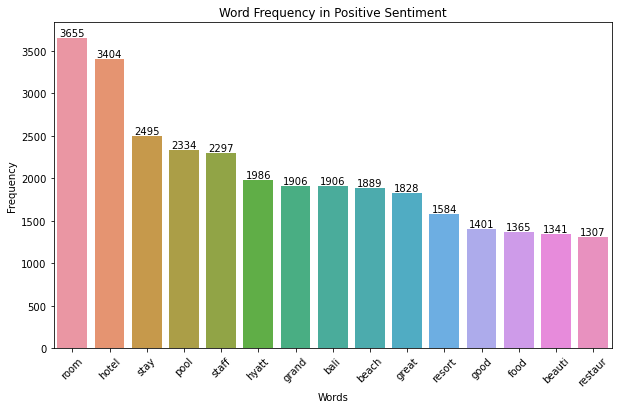

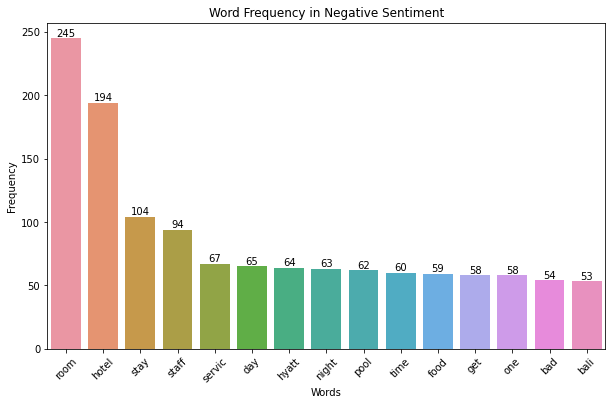

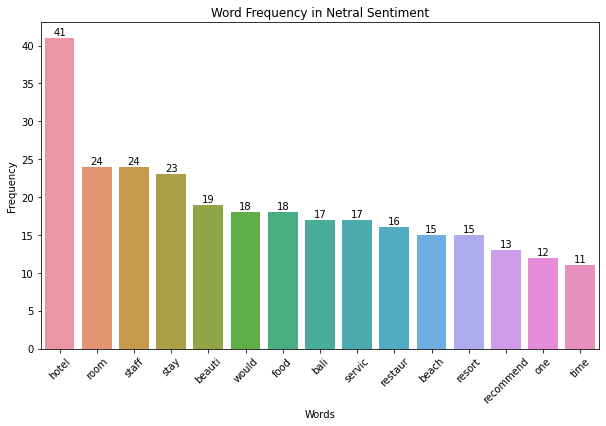

In [19]:
from nltk.probability import FreqDist
def get_word_frequency(tokens):
    freq_dist = FreqDist(tokens)
    return freq_dist

def get_top_words(tokens, n=15):
    freq_dist = FreqDist(tokens)
    top_words = freq_dist.most_common(n)
    return dict(top_words)

def plot_word_frequency(freq_dist, sentiment):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(freq_dist.keys()), y=list(freq_dist.values()))
    plt.title(f'Word Frequency in {sentiment} Sentiment')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    for i, v in enumerate(top_words.values()):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

    plt.show()


for sentiment_category in df['Textblob_Label'].unique():
    sentiment_data = df[df['Textblob_Label'] == sentiment_category]
    combined_tokens = []
    for text in sentiment_data['Review']:
        processed_tokens = tokenizing(text)
        # df['Review'].apply(tokenizing)
        combined_tokens.extend(processed_tokens)
        
    # freq_dist = get_word_frequency(combined_tokens)
    top_words = get_top_words(combined_tokens, n=15)
    plot_word_frequency(top_words, sentiment_category)

In [20]:
X = df['Review']
yTb = df["Textblob_Label"]

In [21]:
X_trainTb, X_testTb, y_trainTb, y_testTb = train_test_split(X, yTb, test_size=0.2, random_state=42)

In [22]:
vectorizer = CountVectorizer()
X_train_vectorizedTb = vectorizer.fit_transform(X_trainTb)
X_test_vectorizedTb = vectorizer.transform(X_testTb)
# print(X_train_vectorizedTb)

  (0, 7010)	1
  (0, 5928)	2
  (0, 2873)	2
  (0, 4433)	1
  (0, 1370)	1
  (0, 4110)	1
  (0, 4580)	1
  (0, 5881)	1
  (0, 2639)	1
  (0, 6868)	1
  (0, 2558)	1
  (0, 3269)	1
  (0, 5649)	1
  (0, 28)	1
  (0, 6700)	1
  (0, 6536)	1
  (0, 659)	2
  (0, 4446)	1
  (0, 4643)	5
  (0, 3724)	1
  (0, 4108)	1
  (0, 6426)	1
  (0, 5513)	1
  (0, 1374)	1
  (0, 1080)	1
  :	:
  (3029, 2406)	1
  (3029, 1884)	1
  (3029, 7011)	1
  (3029, 5443)	1
  (3029, 3288)	1
  (3029, 926)	1
  (3029, 6829)	2
  (3029, 1060)	1
  (3029, 148)	1
  (3029, 779)	1
  (3029, 2275)	1
  (3029, 959)	1
  (3029, 6292)	1
  (3029, 2547)	1
  (3029, 4302)	1
  (3029, 1021)	1
  (3029, 2845)	1
  (3029, 5448)	1
  (3029, 197)	1
  (3029, 680)	1
  (3029, 4567)	1
  (3029, 6567)	1
  (3029, 4312)	1
  (3029, 1662)	1
  (3029, 1333)	1


In [23]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

In [24]:
def plot_roc_curve(y_true, y_probs, model_name):
    n_classes = y_probs.shape[1] if len(y_probs.shape) > 1 else 1

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [25]:
def Compusion_Matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Tanpa Sampling

Model: Naive Bayes

Accuracy: 0.9406332453825857



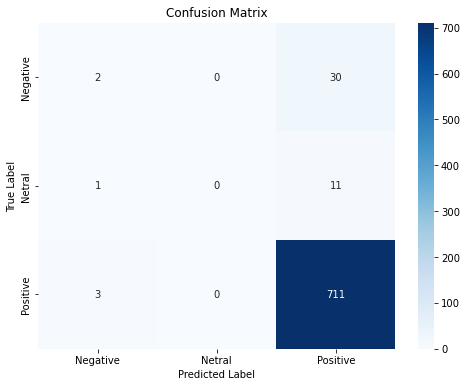

Model: Logistic Regression

Accuracy: 0.9551451187335093



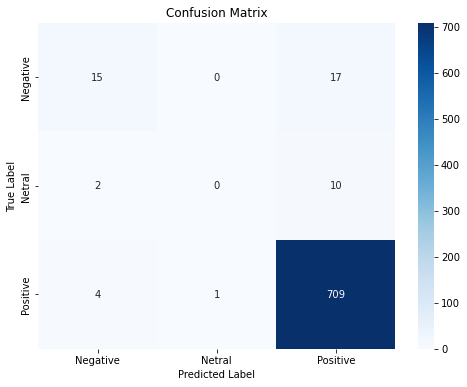

Model: Decision Tree

Accuracy: 0.9366754617414248



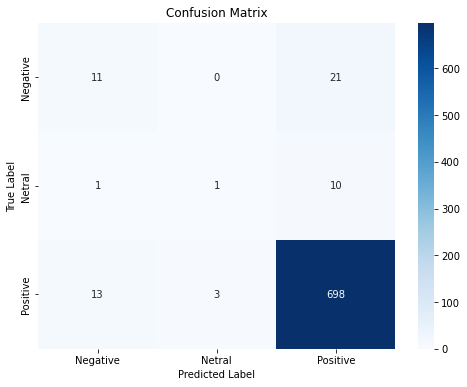

Model: Support Vector Machine

Accuracy: 0.941952506596306



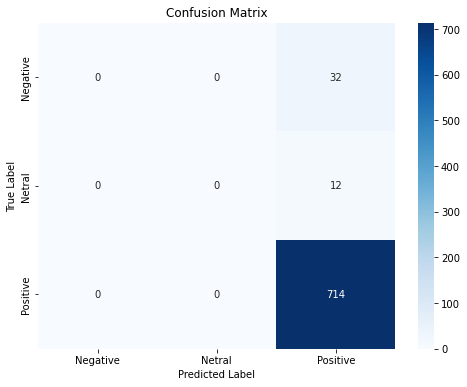

In [26]:
accuracies = []
model_names = []
for name, model in models.items():
    model.fit(X_train_vectorizedTb, y_trainTb)
    y_pred = model.predict(X_test_vectorizedTb)
    accuracy = accuracy_score(y_testTb, y_pred)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}\n')
    print(f'Accuracy: {accuracy}\n')
    Compusion_Matrix(y_testTb, y_pred)

### SMOTE sampling

In [27]:
models2 = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

Model: Naive Bayes

Accuracy: 0.9472295514511874



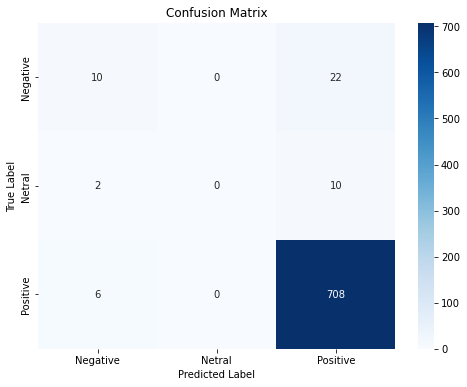

Model: Logistic Regression

Accuracy: 0.9300791556728232



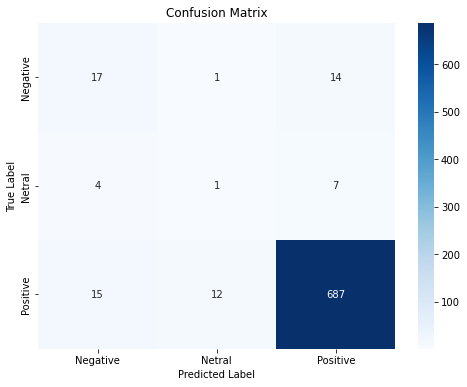

Model: Decission Tree

Accuracy: 0.8825857519788918



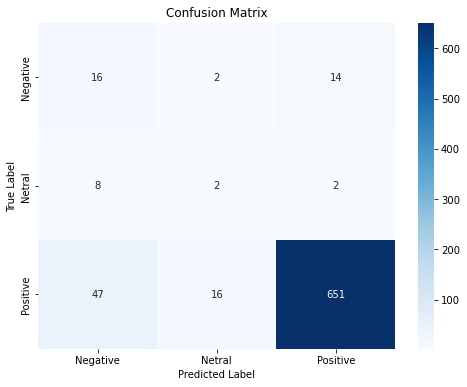

Model: Support Vector Machine

Accuracy: 0.9432717678100264



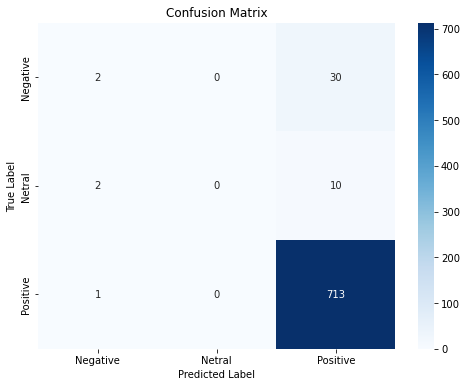

In [28]:
accuracies = []
model_names = []
for name, model in models2.items():
    sm = SMOTE(random_state=777)
    sm_xtrain_cv, sm_train_y = sm.fit_resample(X_train_vectorizedTb, y_trainTb)
    model.fit(sm_xtrain_cv, sm_train_y)
    y_pred = model.predict(X_test_vectorizedTb)
    accuracy = accuracy_score(y_testTb, y_pred)
    
    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}\n')
    print(f'Accuracy: {accuracy}\n')
    Compusion_Matrix(y_testTb, y_pred)


In [29]:
label_count_before = y_trainTb.value_counts()
label_count_after = pd.Series(sm_train_y).value_counts()

# Tampilkan jumlah setiap label
print("Jumlah setiap label sebelum sampling:")
print(label_count_before)

print("\nJumlah setiap label sesudah sampling:")
print(label_count_after)

Jumlah setiap label sebelum sampling:
Positive    2846
Negative     142
Netral        42
Name: Textblob_Label, dtype: int64

Jumlah setiap label sesudah sampling:
Positive    2846
Negative    2846
Netral      2846
Name: Textblob_Label, dtype: int64


## Analisis Sentimen berdasarkan Labelling Rating

In [30]:
df['Rating_Label'] = df['Rating'].apply(getRatingLabel)

In [31]:
df[['Rating','Review','Rating_Label']].head()

,Rating,Review,Rating_Label
0,5,room clean neat food good atmospher brilliant ...,Positive
1,4,fantast resort great locat beauti ocean view r...,Positive
2,5,realli enjoy stay staff accommod ate sever res...,Positive
3,5,excel start finish properti took care us staff...,Positive
4,5,hotel realli amaz wonder time kid staff help c...,Positive


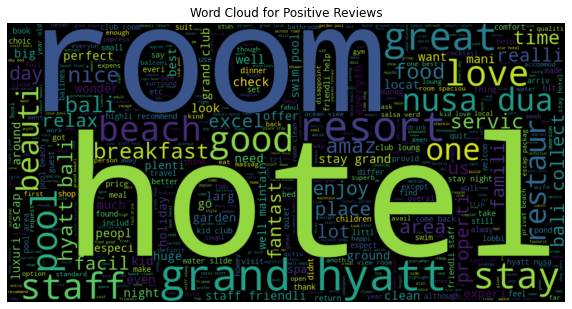

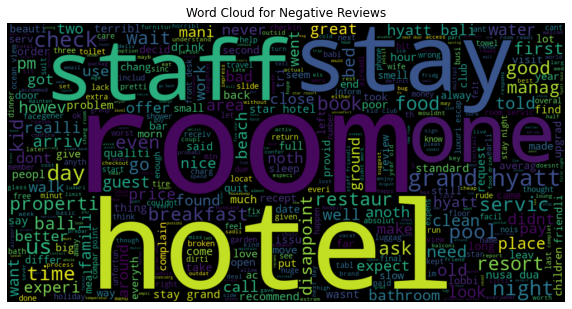

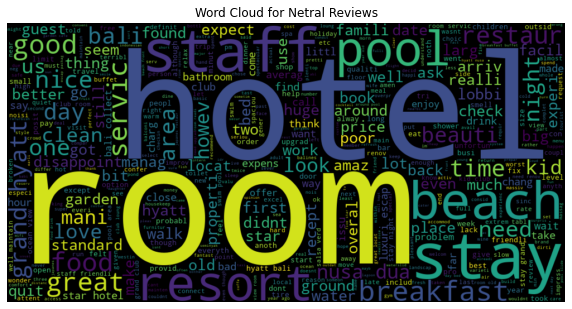

In [32]:
def generate_wordcloud_rating(df, sentiment_label):
    plt.figure(figsize=(10, 10))

    sentiment_text = df.loc[df['Rating_Label'] == sentiment_label, 'Review']
    sentiment_text = sentiment_text.str.cat(sep=' ')

    wc = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    wordcloud = wc.generate(sentiment_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Reviews')
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and 'Rating_Label' contains sentiment labels
generate_wordcloud_rating(df, 'Positive')
generate_wordcloud_rating(df, 'Negative')
generate_wordcloud_rating(df, 'Netral')

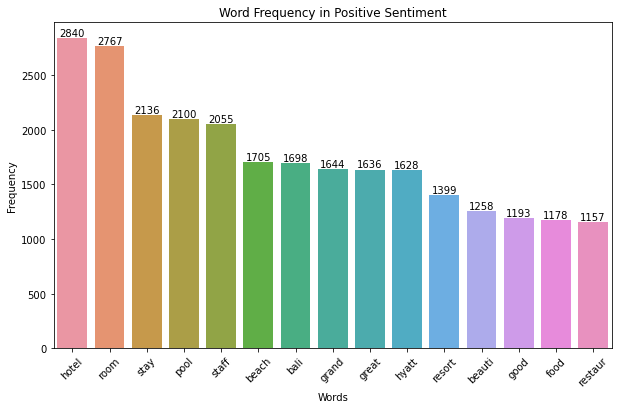

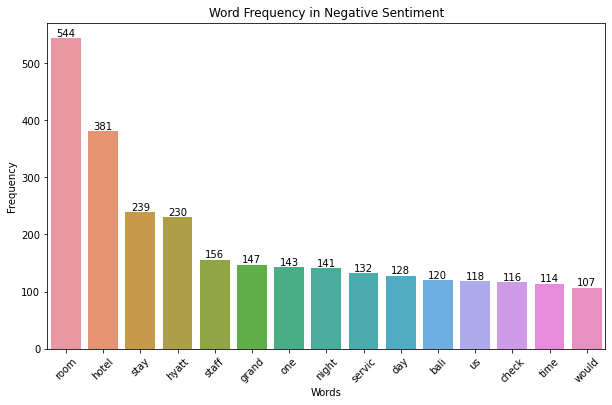

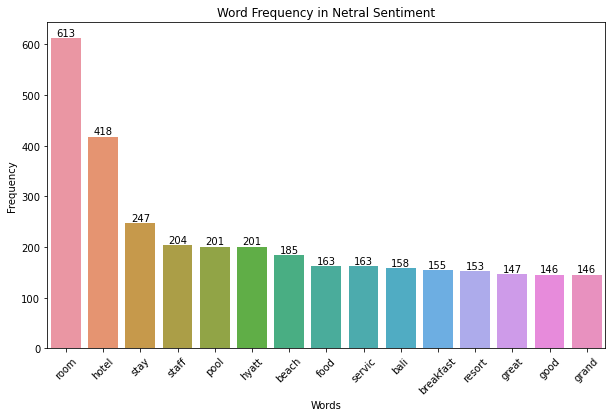

In [41]:
for sentiment_category in df['Rating_Label'].unique():
    sentiment_data = df[df['Rating_Label'] == sentiment_category]
    combined_tokens = []
    for text in sentiment_data['Review']:
        processed_tokens = tokenizing(text)
        # df['Review'].apply(tokenizing)
        combined_tokens.extend(processed_tokens)
        
    # freq_dist = get_word_frequency(combined_tokens)
    top_words = get_top_words(combined_tokens, n=15)
    plot_word_frequency(top_words, sentiment_category)

In [33]:
X = df['Review']
yR = df["Rating_Label"]

In [34]:
XR_train, XR_test, yR_train, yR_test = train_test_split(X, yR, test_size=0.2, random_state=42)

In [35]:
XR_train_vectorized = vectorizer.fit_transform(XR_train)
XR_test_vectorized = vectorizer.transform(XR_test)

In [36]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

### Tanpa Sampling

Model: Naive Bayes

Accuracy: 0.8918205804749341


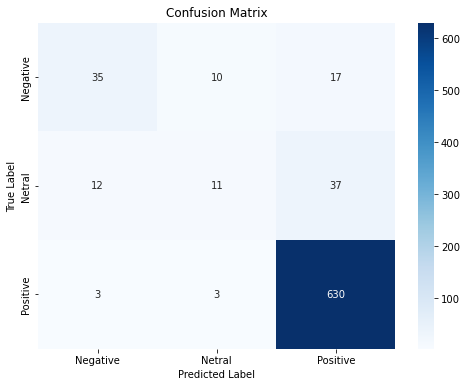

Model: Logistic Regression

Accuracy: 0.8773087071240105


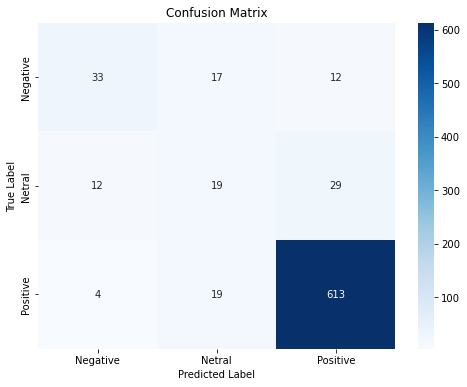

Model: Decission Tree

Accuracy: 0.8007915567282322


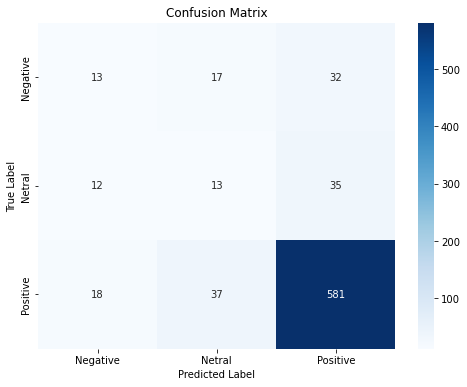

Model: Support Vector Machine

Accuracy: 0.8680738786279684


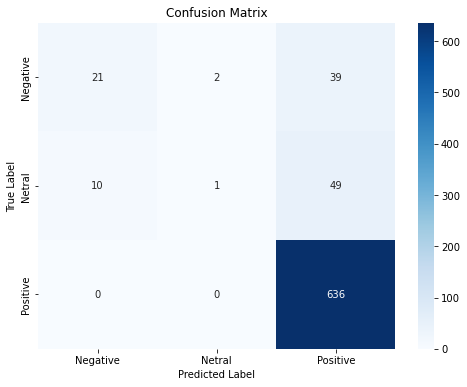

In [37]:
accuracies = []
model_names = []
for name, model in models.items():
    model.fit(XR_train_vectorized, yR_train)
    yR_pred = model.predict(XR_test_vectorized)
    accuracy = accuracy_score(yR_test, yR_pred)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}\n')
    print(f'Accuracy: {accuracy}')
    Compusion_Matrix(yR_test, yR_pred)

### SMOTE Sampling

In [38]:
models2 = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Decission Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC()
}

Model: Naive Bayes
Accuracy: 0.8931398416886543


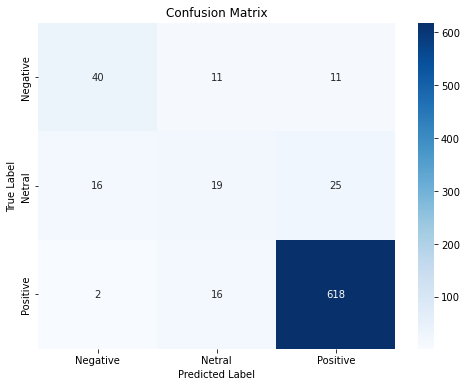

Model: Logistic Regression
Accuracy: 0.837730870712401


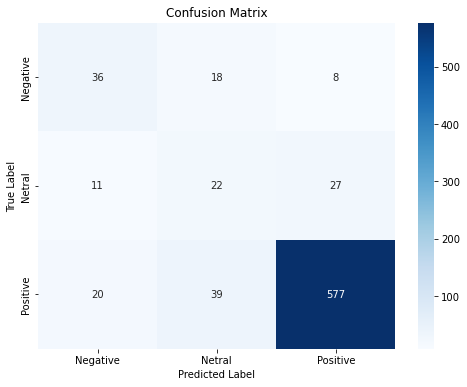

Model: Decission Tree
Accuracy: 0.7018469656992085


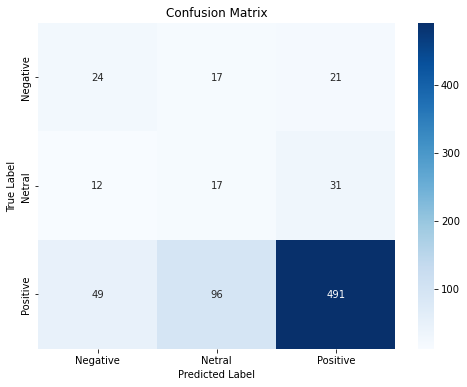

Model: Support Vector Machine
Accuracy: 0.8482849604221636


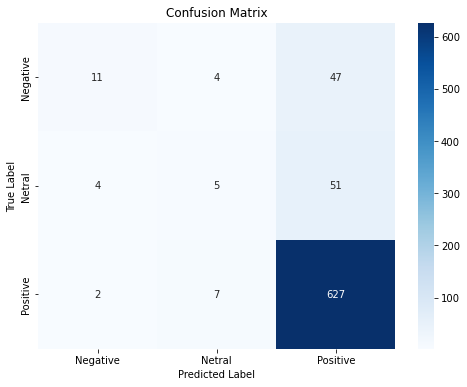

In [39]:
accuracies = []
model_names = []
for name, model in models2.items():
    sm = SMOTE(random_state=777)
    sm_xtrain_cv, sm_train_y = sm.fit_resample(XR_train_vectorized, yR_train)
    model.fit(sm_xtrain_cv, sm_train_y)
    yR_pred = model.predict(XR_test_vectorized)
    accuracy = accuracy_score(yR_test, yR_pred)

    accuracies.append(accuracy)
    model_names.append(name)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    Compusion_Matrix(yR_test, yR_pred)

In [40]:
label_count_before = yR_train.value_counts()
label_count_after = pd.Series(sm_train_y).value_counts()

# Tampilkan jumlah setiap label
print("Jumlah setiap label sebelum sampling:")
print(label_count_before)

print("\nJumlah setiap label sesudah sampling:")
print(label_count_after)

Jumlah setiap label sebelum sampling:
Positive    2448
Netral       311
Negative     271
Name: Rating_Label, dtype: int64

Jumlah setiap label sesudah sampling:
Positive    2448
Negative    2448
Netral      2448
Name: Rating_Label, dtype: int64
